In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

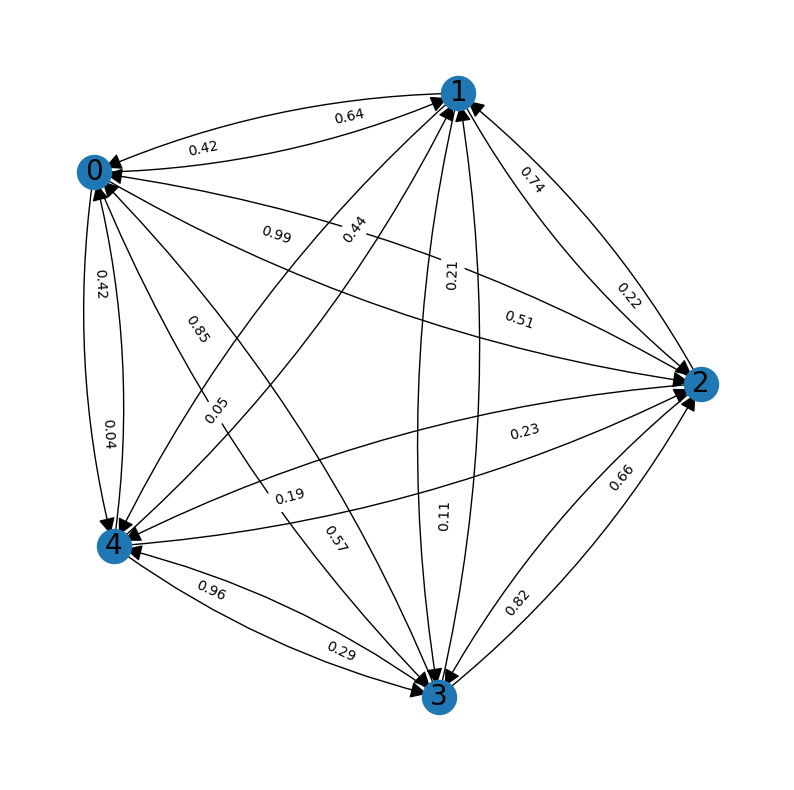

In [5]:
from Simulation import *

from Environment import *


click_probabilities = generate_click_probabilities(fully_connected=True)
observations_probabilities = generate_observation_probabilities(click_probabilities=click_probabilities)

concentration_params = [100] + [70] * NUM_OF_PRODUCTS
alpha_users = np.random.dirichlet( alpha= concentration_params, size = 1)


product_prices, users_reservation_prices = generate_prices(product_range=100, users_range=100)
tot_num_users = 1000


env = Environment(users_reservation_prices = users_reservation_prices,
                    click_probabilities = click_probabilities,
                    observations_probabilities = observations_probabilities,
                    tot_num_users = tot_num_users)

Network.print_graph(G=env.network.G)

In [6]:
nodes_activation_probabilities = env.compute_nodes_activation_probabilities(product_prices=product_prices)

k: 100%|██████████| 4688/4688 [00:02<00:00, 1758.33it/s]


In [7]:
B_cap = 200
budgets = np.arange(start = 0, stop = B_cap+1, step = B_cap/10)

In [32]:
from Ecommerce_step3 import *

In [40]:
ecomm3 = Ecommerce_step3(B_cap = B_cap, budgets = budgets, product_prices = product_prices, tot_num_users = tot_num_users)

In [35]:
sampled_arm_values, arm_idxs = ecomm3.pull_arm(nodes_activation_probabilities=nodes_activation_probabilities)

In [37]:
reward = env.round(pulled_arm=budgets[arm_idxs]/B_cap)

In [38]:
ecomm3.update(pulled_arm = budgets[arm_idxs], reward = reward)

/home/fpuoti/.cache/pypoetry/virtualenvs/ola-project-8LfWcEjO-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
    gts_rewards_per_experiment.append(gts_learner.collected_rewards)
    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

opt = np.max(env.means)
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt-gts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt-gpts_rewards_per_experiment, axis = 0)), 'g')
plt.legend(["GTS", "GPTS"])
plt.show()

In [43]:
gpts_rewards_per_experiment = []
for t in range(10):
    sampled_arm_values, arm_idxs = ecomm3.pull_arm(nodes_activation_probabilities=nodes_activation_probabilities)
    reward = env.round(pulled_arm=budgets[arm_idxs]/B_cap)
    ecomm3.update(pulled_arm = budgets[arm_idxs], reward = reward)
gpts_rewards_per_experiment.append(ecomm3.collected_rewards)

/home/fpuoti/.cache/pypoetry/virtualenvs/ola-project-8LfWcEjO-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fpuoti/.cache/pypoetry/virtualenvs/ola-project-8LfWcEjO-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fpuoti/.cache/pypoetry/virtualenvs/ola-project-8LfWcEjO-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasi

In [44]:
ecomm3.means

array([0.16653574, 0.16695401, 0.16674201, 0.16674201, 0.16674201,
       0.16674201, 0.16674201, 0.16674201, 0.16674201, 0.16674201,
       0.16674201])

In [45]:
env.alpha_bars

array([0.172, 0.173, 0.154, 0.168, 0.183, 0.15 ])

In [46]:
ecomm3.sigmas

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])